In [1]:
import polars as pl
import pandas as pd
import holoviews as hv
import geoviews as gv
import geopandas as gpd
from cartopy import crs as ccrs
import numpy as np
from holoviews.streams import Selection1D
import panel as pn
from scipy.interpolate import Rbf, griddata

In [ ]:
#Set up the bokeh extensions.
gv.extension('bokeh')
hv.extension('bokeh')
pn.extension()

In [2]:
#Set the location of the data.
data_path = "C:\\Users\\mhollaway\\Documents\\JNCC_SLI2_tool\\Test_data\\"

#Read in the NUTS regions - NUTS3 in this example.
NUTS_gdf = gpd.read_file(data_path + 'NUTS_Level_1_January_2018_GCB_in_the_United_Kingdom_2022_-2753267915301604886.geojson')

#Read in the pre-processed data.
all_data       = pl.read_parquet(data_path + "EEX_all_data.parquet")
Sites_info_gdf = gpd.read_parquet(data_path + "Sites_info_gdf.parquet")

<Axes: >

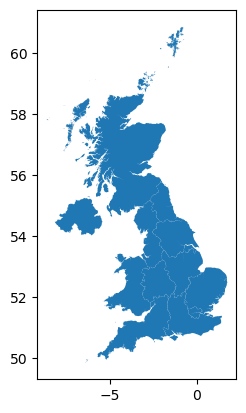

In [3]:
NUTS_gdf.plot()